In [1]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from tensorflow.keras import layers

In [2]:
tf.keras.utils.set_random_seed(30)

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip',
    extract=False)

fname = os.path.join(os.path.dirname(zip_path), 'jena_climate_2009_2016.csv')

In [4]:
with open(fname) as f:
    for _ in range(2):
        print(f.readline())

"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"

01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30



In [5]:
df = pd.read_csv(fname)
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
temperature = df['T (degC)']
df.columns

Index(['p (mbar)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)',
       'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)',
       'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)'],
      dtype='object')

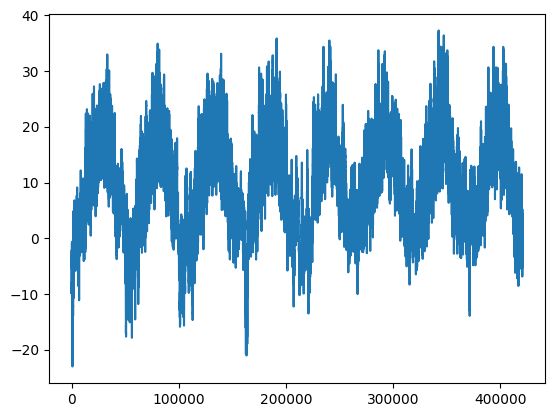

In [6]:
plt.plot(temperature)

**Plotting the first 10 days of the temperature timeseries**

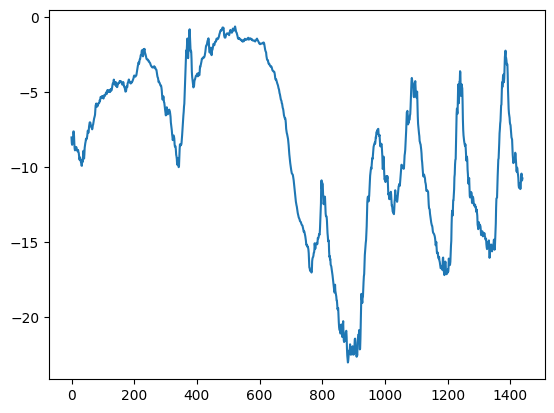

In [7]:
# 6 (samples by hour) * 24 * 10 = 1440
plt.plot(temperature[:1440])

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420451.0,989.212508,8.359454,913.60,984.20,989.57,994.72,1015.35
Tpot (K),420451.0,283.491182,8.504820,250.60,277.43,283.46,289.53,311.34
Tdew (degC),420451.0,4.954011,6.730411,-25.01,0.24,5.21,10.07,23.11
rh (%),420451.0,76.007045,16.477126,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420451.0,13.575089,7.739481,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420451.0,9.532524,4.183895,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420451.0,4.042483,4.897270,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420451.0,6.021630,2.655973,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420451.0,9.638982,4.235130,0.80,6.29,8.96,12.48,28.82
rho (g/m**3),420451.0,1216.069883,39.977065,1059.45,1187.49,1213.80,1242.77,1393.54


### Feature Engineering

In [9]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [10]:
num_features = df.columns.size

In [11]:
num_train_samples = int(0.5 * len(df))
num_val_samples = int(0.75 * len(df)) - num_train_samples
num_test_samples = len(df) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105113
num_test_samples: 105113


In [12]:
mean = df[:num_train_samples].mean()
std = df[:num_train_samples].std()
df = (df - mean) / std

Each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples, each containing 120 consecutive hours of input data, and targets is the corresponding array of 256 target temperatures.

In [13]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    df[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    df[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    df[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [14]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 18)
targets shape: (256,)


In [15]:
inputs = tf.keras.Input(shape=(sequence_length, num_features))
x = layers.Conv1D(64, 3, padding='causal', activation='relu')(inputs)
x = layers.GRU(32, return_sequences=True)(x)
x = layers.GRU(32)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset.repeat(),
                    epochs=12,
                    validation_data=val_dataset,
                    steps_per_epoch=200,
                    callbacks=callbacks)
                    
model = tf.keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

os.remove("jena_stacked_gru_dropout.keras")

Epoch 1/12
200/200 [==============================] - 17s 56ms/step - loss: 48.0215 - mae: 5.0700 - val_loss: 10.6656 - val_mae: 2.4980
Epoch 2/12
200/200 [==============================] - 11s 55ms/step - loss: 21.0458 - mae: 3.4640 - val_loss: 10.9342 - val_mae: 2.5913
Epoch 3/12
200/200 [==============================] - 10s 51ms/step - loss: 19.5020 - mae: 3.3526 - val_loss: 9.7249 - val_mae: 2.4363
Epoch 4/12
200/200 [==============================] - 12s 59ms/step - loss: 19.4357 - mae: 3.3254 - val_loss: 8.1380 - val_mae: 2.2272
Epoch 5/12
200/200 [==============================] - 12s 62ms/step - loss: 19.0025 - mae: 3.3030 - val_loss: 11.6192 - val_mae: 2.7006
Epoch 6/12
200/200 [==============================] - 12s 62ms/step - loss: 18.6435 - mae: 3.2554 - val_loss: 9.7450 - val_mae: 2.4399
Epoch 7/12
200/200 [==============================] - 13s 64ms/step - loss: 17.7916 - mae: 3.1775 - val_loss: 9.9030 - val_mae: 2.4630
Epoch 8/12
200/200 [==============================] 

```
# Feature Enginnering, optimizer="rmsprop", loss="mse", steps_per_epoch=200
x = layers.Conv1D(64, 3, padding='causal', activation='relu')(inputs)
x = layers.GRU(32, return_sequences=True)(x)
x = layers.GRU(32)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.4)(x)
Test MAE: 2.34

# Feature Enginnering, optimizer="rmsprop", loss="mse"
x = layers.Conv1D(64, 3, padding='causal', activation='relu')(inputs)
x = layers.GRU(32, return_sequences=True)(x)
x = layers.GRU(32)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.4)(x)
Test MAE: 2.37

# Feature Enginnering, optimizer="rmsprop", loss="mse"
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
Test MAE: 2.39

# Feature Enginnering, optimizer="rmsprop", loss="mse", steps_per_epoch=200
x = layers.Conv1D(64, 3, padding='causal', activation='relu')(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Bidirectional(layers.GRU(32, return_sequences=True))(x)
x = layers.LSTM(16)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.4)(x)
Test MAE: 2.41

# Feature Enginnering, optimizer="adam", loss="huber"
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
Test MAE: 2.44

# No Feature Enginnering, optimizer="rmsprop", loss="mse"
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
Test MAE: 2.47

# No Feature Enginnering, optimizer="adam", loss="huber"
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
Test MAE: 2.49

# No Feature Enginnering, optimizer="rmsprop", loss="mse"
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
x = layers.Dropout(0.5)(x)
Test MAE: 2.72

```